# **Analisis Eda del proyecto**


## *Contexto y objetivos*

La tasa de natalidad ha disminuido en los últimos años en varios países, mientras que en otros esta tasa de natalidad aún se mantiene alta. Estos cambios llegan a ser un gran indicador para poder comprender el desarrollo económico y social de un país.

Analizar las causas de estos cambios es clave para entender fenómenos como el envejecimiento poblacional, la migración o el crecimiento económico. Este proyecto busca ver cómo distintas variables (como el nivel educativo, acceso a  salud, urbanización, etc.) se relacionan con la tasa de natalidad. Queremos explorar con datos desde 1965 hasta 2010 que correlacion tienen estas distintas variables con el aumento o disminucion en la tasa de natalidad.

### _Referencias_:
- https://www.bbc.com/mundo/noticias-53417504
- https://theconversation.com/se-esta-produciendo-un-colapso-demografico-mundial-234291

## Recordamos las preguntas de investigacion:

1) ¿Existe relación entre el nivel de urbanización y las tasas de natalidad?  
  
2) ¿Existen patrones regionales o económicos que expliquen diferencias en natalidad? 
  
3) ¿Puede predecirse la tasa de natalidad de un país en base a sus condiciones socioeconómicas? 
  
4) ¿Qué  países  se  comportan  como  outliers  (tienen  tasas  de  natalidad  inusuales  dadas  sus 
características)? 
  
5) ¿Cómo  han  cambiado  las  tasas  de  natalidad  en  las  últimas  dos  décadas,  y  qué  variables  se 
relacionan con esos cambios? 

In [18]:
# Librerias a importar
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import json
import time
from os import path

# Datos

Vamos a ocupar principalmente datos publicos del **Banco Mundial**, ademas de los siguientes datos:

#### Apis a utilizar:
- Banco Mundial (https://data.worldbank.org)  
- Our World in Data (https://ourworldindata.org)  
- World Meter (https://worldometer.readthedocs.io/en/latest)  
- Datos Macro (https://datosmacro.expansion.com/demografia/natalidad)  
- API (https://opengateway.telefonica.com/apis/population-density-data)  
- https://www.ine.gob.cl/estadisticas/sociales/censos-de-poblacion-y-vivienda/censo-de-poblacion-y-vivienda


Para este analisis, vamos a extraer los datos mediante sus API's.

In [19]:
# Primer intento de creacion de dataframe total
"""
link_banco_mundial_total = "https://data.worldbank.org/indicator/SP.POP.TOTL"
link_banco_mundial_urbana = "https://data.worldbank.org/indicator/SP.URB.TOTL"
link_banco_mundial_fertilidad = "  https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json"
datos_macro_natalidad_html = "https://datosmacro.expansion.com/demografia/natalidad"

indicadores = ["SP.POP.TOTL","SP.URB.TOTL","SP.POP.TOTL"]
dataframes = []
# Hacemos la primera solicitud para saber cuántas páginas hay
for i in indicadores:
    url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"
    response = requests.get(url_base)
    data = response.json()
    total_pages = data[0]['pages']
    print(f"Total de páginas: {total_pages}")

    # Lista para guardar todos los datos
    all_data = []

    # Iterar por todas las páginas
    for page in range(1, total_pages + 1):
        response = requests.get(f"{url_base}&page={page}")
        page_data = response.json()[1]  # los datos están en la segunda posición
        all_data.extend(page_data)

    # Normalizamos el JSON y añadimos columna del indicador
    df = pd.json_normalize(all_data)
    df["indicator_id"] = i # <- esto permite identificar de qué indicador viene
    dataframes.append(df)

# Unificamos todos los DataFrames en uno solo
df_total = pd.concat(dataframes, ignore_index=True)
df_total
"""

# Version anterior del bloque de codigo inferior
'''
for i in indicadores:
    print(f"\nDescargando datos de: {i}")
    url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"

    # Primera solicitud para saber cuántas páginas hay
    response = requests.get(url_base)
    
    # SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
    try:
        data = response.json()
    except Exception:
        print(f"No se pudo decodificar JSON para {i} (respuesta vacía o error del servidor).")
        continue

    if not isinstance(data, list) or len(data) < 2:
        print(f"Sin datos válidos para {i}.")
        continue

    total_pages = data[0]['pages']
    print(f"Total de páginas para {i}: {total_pages}")

    all_data = []

    # Iterar por todas las páginas
    for page in range(1, total_pages + 1):
        url = f"{url_base}&page={page}"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Error en la página {page} de {i} (HTTP {response.status_code})")
            continue

        #SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
        try: 
            page_json = response.json()
            if len(page_json) < 2:
                print(f"Página {page} vacía para {i}")
                continue
            page_data = page_json[1]
            all_data.extend(page_data)

        except Exception:
            print(f"Error al decodificar JSON en página {page} de {i}")
            continue

        # Pequeña pausa para evitar sobrecargar el servidor
        time.sleep(0.3)

    # SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
    if all_data: 
        df = pd.json_normalize(all_data)
        df["indicator_id"] = i
        dataframes.append(df)
        print(f"{len(all_data)} registros añadidos de {i}")
    else:
        print(f"No se añadieron datos para {i}")

# Unificamos todos los DataFrames
if dataframes:
    df_total = pd.concat(dataframes, ignore_index=True)
    print(f"Data unificada con {len(df_total)} registros totales")
else:
    df_total = pd.DataFrame()
    print("No se pudieron descargar datos válidos.")

df_total.head()
'''

'\nfor i in indicadores:\n    print(f"\nDescargando datos de: {i}")\n    url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"\n\n    # Primera solicitud para saber cuántas páginas hay\n    response = requests.get(url_base)\n\n    # SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS\n    try:\n        data = response.json()\n    except Exception:\n        print(f"No se pudo decodificar JSON para {i} (respuesta vacía o error del servidor).")\n        continue\n\n    if not isinstance(data, list) or len(data) < 2:\n        print(f"Sin datos válidos para {i}.")\n        continue\n\n    total_pages = data[0][\'pages\']\n    print(f"Total de páginas para {i}: {total_pages}")\n\n    all_data = []\n\n    # Iterar por todas las páginas\n    for page in range(1, total_pages + 1):\n        url = f"{url_base}&page={page}"\n        response = requests.get(url)\n        if response.status_code != 200:\n            print(

In [20]:
# Nueva funcion para descargar los archivos desde la API de WorldBank
# Ahora deberia de guardar los archivos descargados en un CSV una vez termine

# Los datos se tardan en cargar aproximadamente 8 minutos con 30 segundos
def descargar_datos_desde_worldbank():
    indicadores = ["SP.POP.TOTL", "SP.URB.TOTL", "SP.DYN.TFRT.IN", "SP.DYN.CBRT.IN", "SP.DYN.CDRT.IN",
                    "EN.POP.DNST", "SP.DYN.LE00.IN", "SE.ADT.LITR.ZS", "SH.STA.MMRT"]
    dataframes = []
    archivo_csv = "datos_worldbank.csv"

    # Verificar si los datos fueron descargados con anterioridad
    if path.exists(archivo_csv):
        print(f"Archivo {archivo_csv} encontrado. Cargando datos desde el archivo...")
        df_total = pd.read_csv(archivo_csv)
        print(f"Datos cargados exitosamente: {len(df_total)} registros")
        return df_total

    # Si no existe el archivo, descargar los datos
    print("No se encontro archivo.\n"
        "Iniciando descarga de datos desde la API...")
    
    for i in indicadores:
        print(f"\nDescargando datos de: {i}")
        url_base = f"http://api.worldbank.org/v2/country/all/indicator/{i}?format=json&per_page=100"

        # Primera solicitud para saber cuántas páginas hay
        response = requests.get(url_base)
        
        # SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
        try:
            data = response.json()
        except Exception:
            print(f"No se pudo decodificar JSON para {i} (respuesta vacía o error del servidor).")
            continue

        if not isinstance(data, list) or len(data) < 2:
            print(f"Sin datos válidos para {i}.")
            continue

        total_pages = data[0]['pages']
        print(f"Total de páginas para {i}: {total_pages}")

        all_data = []

        # Iterar por todas las páginas
        for page in range(1, total_pages + 1):
            url = f"{url_base}&page={page}"
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Error en la página {page} de {i} (HTTP {response.status_code})")
                continue

            # SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
            try: 
                page_json = response.json()
                if len(page_json) < 2:
                    print(f"Página {page} vacía para {i}")
                    continue
                page_data = page_json[1]
                all_data.extend(page_data)

            except Exception:
                print(f"Error al decodificar JSON en página {page} de {i}")
                continue

            # Pequeña pausa para evitar sobrecargar el servidor
            time.sleep(0.1)

        # SEGUROS PARA QUE NO LANZE ERROR POR ERRORES DE FORMATO EN ALGUNOS DE LOS LINKS INTERMEDIOS
        if all_data: 
            df = pd.json_normalize(all_data)
            df["indicator_id"] = i
            dataframes.append(df)
            print(f"{len(all_data)} registros añadidos de {i}")
        else:
            print(f"No se añadieron datos para {i}")

    # Unificamos todos los DataFrames
    if dataframes:
        df_total = pd.concat(dataframes, ignore_index=True)
        print(f"Data unificada con {len(df_total)} registros totales")
        
        # Guardar en CSV
        try:
            df_total.to_csv(archivo_csv, index=False)
            print(f"Datos guardados exitosamente en {archivo_csv}")
        except Exception as e:
            print(f"Error al guardar en CSV: {e}")
    else:
        df_total = pd.DataFrame()
        print("No se pudieron descargar datos válidos.")

    return df_total

In [21]:
df_total = descargar_datos_desde_worldbank()
df_total.head()

Archivo datos_worldbank.csv encontrado. Cargando datos desde el archivo...
Datos cargados exitosamente: 155610 registros


,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,indicator_id
0,AFE,2024,769294618.0,NaN,NaN,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
1,AFE,2023,750503764.0,NaN,NaN,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
2,AFE,2022,731821393.0,NaN,NaN,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
3,AFE,2021,713090928.0,NaN,NaN,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL
4,AFE,2020,694446100.0,NaN,NaN,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern,SP.POP.TOTL


In [22]:
df_total.groupby("indicator.value").agg("count")

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,country.id,country.value,indicator_id
indicator.value,,,,,,,,,,
"Birth rate, crude (per 1,000 people)",16965,17290,16930,0,0,17290,17290,17225,17290,17290
"Death rate, crude (per 1,000 people)",16965,17290,16930,0,0,17290,17290,17225,17290,17290
"Fertility rate, total (births per woman)",16965,17290,16928,0,0,17290,17290,17225,17290,17290
"Life expectancy at birth, total (years)",16965,17290,16926,0,0,17290,17290,17225,17290,17290
"Literacy rate, adult total (% of people ages 15 and above)",16965,17290,2828,0,0,17290,17290,17225,17290,17290
"Maternal mortality ratio (modeled estimate, per 100,000 live births)",16965,17290,9438,0,0,17290,17290,17225,17290,17290
Population density (people per sq. km of land area),16965,17290,15296,0,0,17290,17290,17225,17290,17290
"Population, total",16965,17290,17195,0,0,17290,17290,17225,17290,17290
Urban population,16965,17290,17065,0,0,17290,17290,17225,17290,17290


Agrupamos df_total por pais (country.value) y año (date) y lo guardamos en df_pivot, despues se añade la columna `urban_rate` que contiene el porcentaje de poblacion urbana de cada pais. Por ultimo, cambiamos el tipo de la columna date a int y quitamos todas las filas que contienen datos NaN en las columnas indicadas. 

In [23]:
# Pivotear el df_total para tener columnas por indicador
df_pivot = df_total.pivot_table(
    index=["country.value", "date"],
    columns="indicator_id",
    values="value"
).reset_index()

# Calcular nivel de urbanización (% de población urbana)
df_pivot["urban_rate"] = (df_pivot["SP.URB.TOTL"] / df_pivot["SP.POP.TOTL"]) * 100

# Limpiar años y convertir valores numéricos
df_pivot["date"] = df_pivot["date"].astype(int)
df_pivot = df_pivot.dropna(subset=["SP.DYN.TFRT.IN", "urban_rate"])

In [24]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16800 entries, 0 to 17198
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country.value   16800 non-null  object 
 1   date            16800 non-null  int64  
 2   EN.POP.DNST     15283 non-null  float64
 3   SE.ADT.LITR.ZS  2771 non-null   float64
 4   SH.STA.MMRT     9433 non-null   float64
 5   SP.DYN.CBRT.IN  16800 non-null  float64
 6   SP.DYN.CDRT.IN  16800 non-null  float64
 7   SP.DYN.LE00.IN  16796 non-null  float64
 8   SP.DYN.TFRT.IN  16800 non-null  float64
 9   SP.POP.TOTL     16800 non-null  float64
 10  SP.URB.TOTL     16800 non-null  float64
 11  urban_rate      16800 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.7+ MB


Generamos un scatterplot que muestra la relacion entre el porentaje de poblacion urbana y tasa de fertilidad

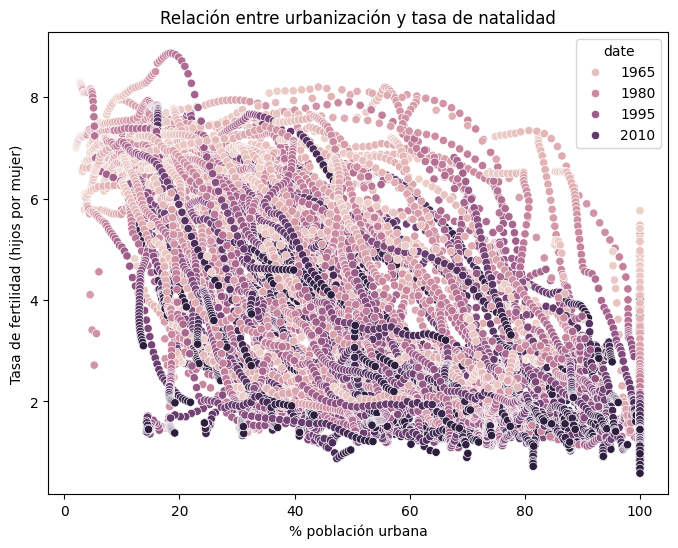

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pivot,
    x="urban_rate", 
    y="SP.DYN.TFRT.IN", 
    hue='date'
)
plt.title("Relación entre urbanización y tasa de natalidad")
plt.xlabel("% población urbana")
plt.ylabel("Tasa de fertilidad (hijos por mujer)")
plt.show()


En este primer grafico se puede observar que alrededor de 1965 la tasa de fertilidad es alta (aproximadamente 5-7 hijos por mujer) y su porcentaje de poblacion urbana es aproximadamente menor al 40%. Tambien, se logra observar que mientras pasan los años la tasa de fertilidad va disminuyendo (llegando aproximadamente 2-4 hijos por mujer en 2010) y a su vez, el porcentaje de poblacion urbana va creciendo.

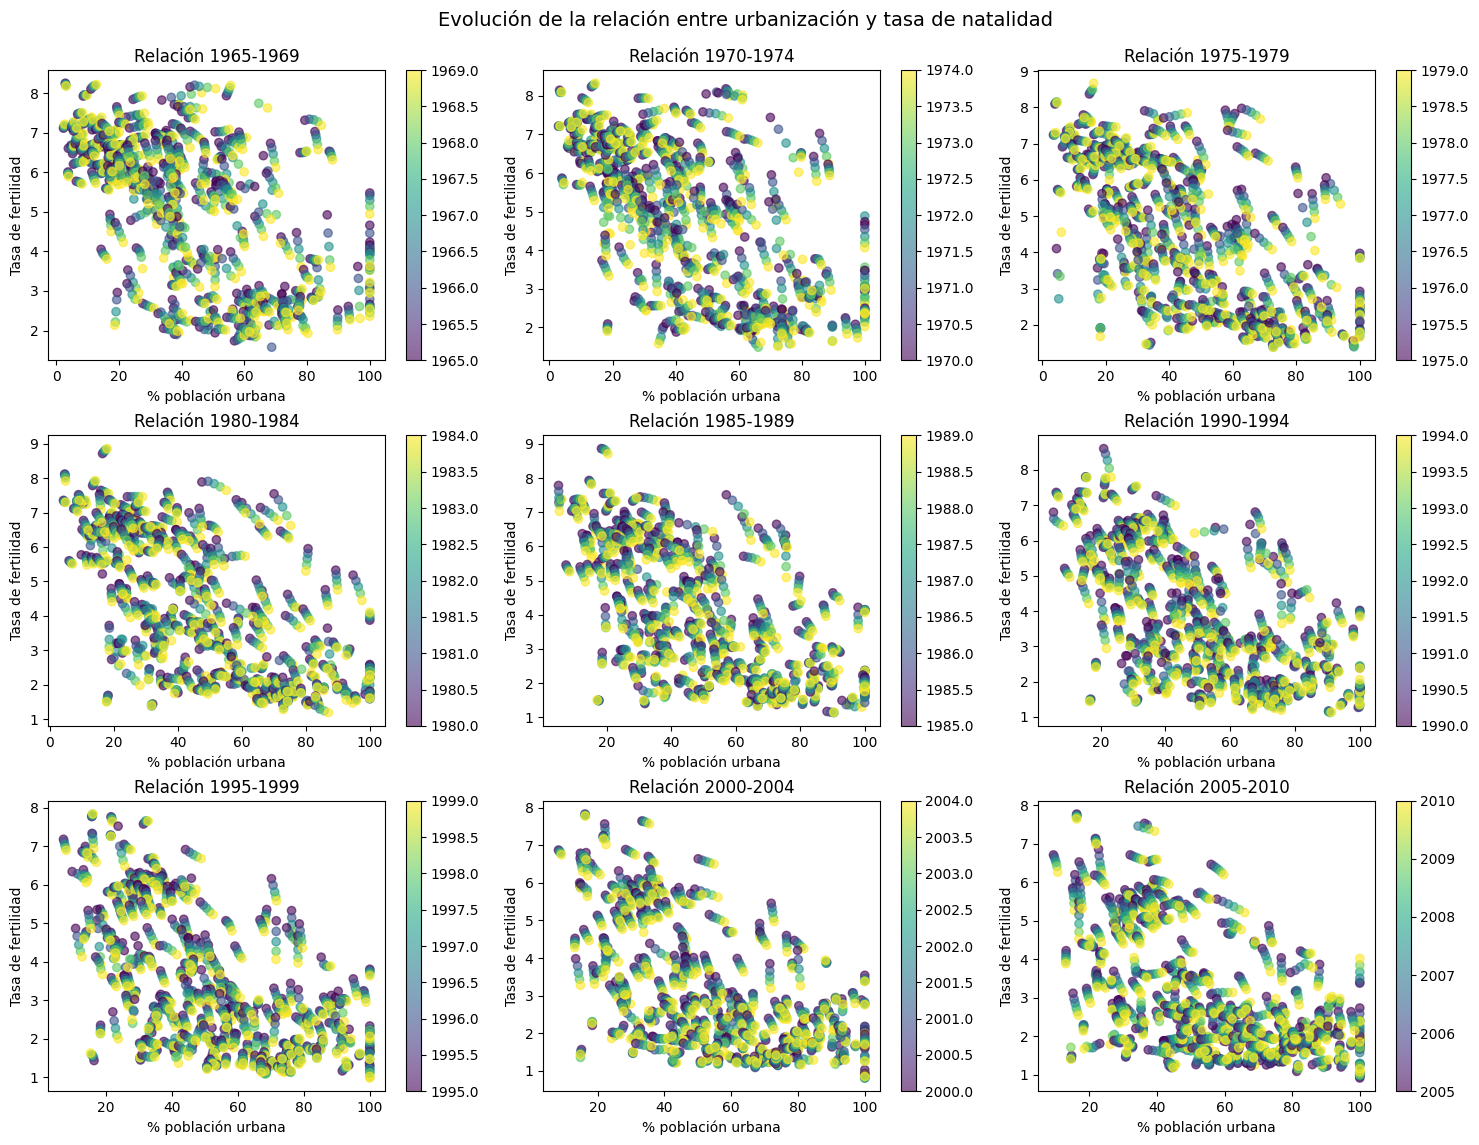

In [26]:
## Posible alternativa de varios graficos dividos en una matriz 3x3.
# 1) Desconozco si los datos realmente llegan desde 1965 al 2010
# 1.1) En caso de ser necesario los rangos pueden ajustarse modificando la lista de tuplas: "year_range"
# 2) No ha sido probado ya que no tengo tiempo de descargar los datos, al tiempo de realizar este commit.

# Crear rangos de años de 5 en 5
year_ranges = [
    (1965, 1969),
    (1970, 1974),
    (1975, 1979),
    (1980, 1984),
    (1985, 1989),
    (1990, 1994),
    (1995, 1999),
    (2000, 2004),
    (2005, 2010)
]

# Crear figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()  # Aplanar para iterar fácilmente

for idx, (start_year, end_year) in enumerate(year_ranges):

    # Filtrar datos para el rango de años actual
    mask = (df_pivot['date'] >= start_year) & (df_pivot['date'] <= end_year)
    df_range = df_pivot.loc[mask]
    
    # Crear scatter plot en el subgráfico correspondiente
    sc = axes[idx].scatter(
        x=df_range["urban_rate"],
        y=df_range["SP.DYN.TFRT.IN"],
        c=df_range["date"],
        cmap="viridis",
        alpha=0.6
    )
    
    # Añadir una colorbar individual para cada subgráfico
    plt.colorbar(sc, ax=axes[idx])
    
    axes[idx].set_title(f"Relación {start_year}-{end_year}")
    axes[idx].set_xlabel("% población urbana")
    axes[idx].set_ylabel("Tasa de fertilidad")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Evolución de la relación entre urbanización y tasa de natalidad", fontsize=14, y=0.95)
plt.show()

Ahora, teniendo las fechas dividas en distintos graficos se puede observar que entre 1965-1975 la mayoria de los puntos se encuentran en el rango de alta fertilidad (5-8 hijos por mujer) y que hay un bajo nivel de urbanizacion (aproximadamente menor al 50%), mientras que en años como 1980 hasta 1995, estos puntos avanzan a un mayor porcentaje de urbanizacion y que a su vez se va disminuyendo la tasa de fertilidad. Ya estando entre 2000-2010, se observa que la mayoria de los puntos tienen una muy baja tasa de fertilidad, estando la mayoria de puntos por debajo de 3 hijos por mujer y ademas teniendo un porcentaje de poblacion urbana aproximadamente mayor al 60%. Esto nos da una vision mas detallada a lo que pasa en cada año, dejando a ver que mientras pasan los años es mayor el porcentaje de poblacion urbana y a su vez menor es la tasa de fertilidad, confirmandonos las suposiciones que hicimos en el primer grafico.

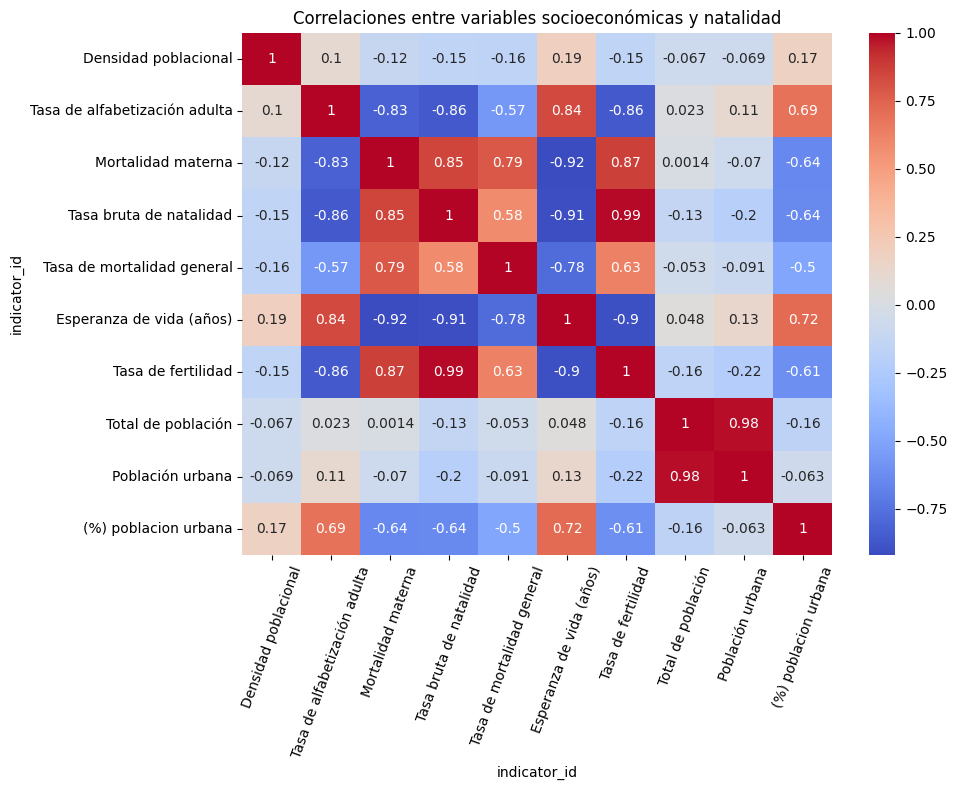

In [27]:
df_pivot2 = df_total.pivot_table(
    index=["country.value", "date"],
    columns="indicator_id",
    values="value"
).reset_index()

# Calcular nivel de urbanización (% de población urbana)
df_pivot2["urban_rate"] = (df_pivot2["SP.URB.TOTL"] / df_pivot2["SP.POP.TOTL"]) * 100

# Se renombran las columnas para facilitar la lectura y visualizacion de datos
df_pivot2 = df_pivot2.rename(columns={'EN.POP.DNST': 'Densidad poblacional', 'SE.ADT.LITR.ZS': 'Tasa de alfabetización adulta',
                                    'SH.STA.MMRT': 'Mortalidad materna', 'SP.DYN.CBRT.IN': 'Tasa bruta de natalidad',
                                    'SP.DYN.CDRT.IN': 'Tasa de mortalidad general', 'SP.DYN.LE00.IN': 'Esperanza de vida (años)',
                                    'SP.DYN.TFRT.IN': 'Tasa de fertilidad', 'SP.POP.TOTL': 'Total de población',
                                    'SP.URB.TOTL': 'Población urbana', 'urban_rate': '(%) poblacion urbana'})
numeric_df = df_pivot2.drop(columns=['country.value', "date"]).dropna()

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlaciones entre variables socioeconómicas y natalidad")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()


## Conclusiones preliminares

text

In [28]:

# Csv DIRECTO our world in data
df = pd.read_csv("https://ourworldindata.org/grapher/distribution-of-population-poverty-thresholds.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2743 entries, 0 to 2742
Data columns (total 13 columns):
 #   Column                                                                                                                                                                        Non-Null Count  Dtype 
---  ------                                                                                                                                                                        --------------  ----- 
 0   Entity                                                                                                                                                                        2743 non-null   object
 1   Code                                                                                                                                                                          2241 non-null   object
 2   Year                                                                            